# Verification Example 1 - Console

In [20]:
# units in kN, cm and second

Lx, Ly, Lz = 100., 15., 10.  # size of the grid
nx, ny, nz = 4, 2, 2  # desity of the grid

d = 1.2  # outer diameter of the tube
t = 0.4  # thickness of the tube

Ex = 21000.0
nu = 0.25
fy = 35.0
wpuv = 78.5e-6  # kN / cm3, 7850 kg / m3

Fx, Fy, Fz = 1.0, 1.0, 1.0
qx, qy, qz = 1.0, 1.0, 1.0


In [21]:
from linkeddeepdict import LinkedDeepDict
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn
from sigmaepsilon.solid.fourier.symtools import inv_sym_3x3
from neumann.array import atleastnd
from time import time

import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
from copy import copy
import matplotlib.pyplot as plt

summary = LinkedDeepDict()

MyDocument({})

In [22]:
from polymesh.space import StandardFrame, PointCloud
from polymesh.grid import gridH8 as grid
from polymesh.topo.tr import H8_to_L2
import numpy as np

gridparams = {
    'size': (Lx, Ly, Lz),
    'shape': (nx, ny, nz),
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)
coords, topo = H8_to_L2(coords, topo)

GlobalFrame = StandardFrame(dim=3)

points = PointCloud(coords, frame=GlobalFrame).centralize()
dx = - np.array([points[:, 0].min(), 0., 0.])
points.move(dx)
coords = points.show()


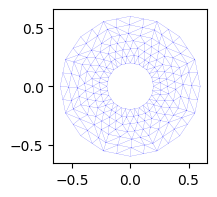

In [23]:
from sigmaepsilon.solid import BeamSection
from linkeddeepdict.tools import getallfromkwargs
from polymesh.tri.trimesh import triangulate
from polymesh.topo.tr import T6_to_T3
import matplotlib.pyplot as plt
from dewloosh.mpl import triplot

section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])

scoords, stopo = section.coords(), section.topology()
path = np.array([[0, 5, 4], [5, 1, 3], [3, 2, 4], [5, 3, 4]], dtype=int)
scoords, stopo = T6_to_T3(scoords, stopo, path=path)
triobj = triangulate(points=scoords, triangles=stopo)[-1]
fig, ax = plt.subplots(figsize=(7, 2))
triplot(triobj, fig=fig, ax=ax, lw=0.1)


In [ ]:
from linkeddeepdict import LinkedDeepDict

loads = LinkedDeepDict()

# load case 1
loads['LC1', 'description'] = 'concentrated force at the free end in X direction'
loads['LC1', 'position'] = [Lx, 0, 0]
loads['LC1', 'value'] = [Fx, 0, 0, 0, 0, 0]
loads['LC1', 'result'] = Fx * Lx / (Ex * A)

# load case 2
loads['LC2', 'description'] = 'concentrated force at the free end in Y direction'
loads['LC2', 'position'] = [Lx, 0, 0]
loads['LC2', 'value'] = [0, Fy, 0, 0, 0, 0]
loads['LC2', 'result'] = Fy * Lx**3 / (3 * Ex * Iy)

# load case 3
loads['LC3', 'description'] = 'concentrated force at the free end in Z direction'
loads['LC3', 'position'] = [Lx, 0, 0]
loads['LC3', 'value'] = [0, 0, Fz, 0, 0, 0]
loads['LC3', 'result'] = Fz * Lx**3 / (3 * Ex * Iz)


## Solution

### Linear Solution

In [27]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from polymesh.space import StandardFrame, frames_of_lines
from polymesh.space.utils import index_of_closest_point
from sigmaepsilon.solid.fem.cells import B2 as Beam

# space
GlobalFrame = StandardFrame(dim=3)

# essential boundary conditions
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
fixity[ebcinds, :] = True

# natural boundary conditions
nLoadCase = len(loads)
nodal_loads = np.zeros((coords.shape[0], 6, nLoadCase))
for iLC, key in enumerate(loads):
    x = loads[key]['position']
    f = loads[key]['value']
    iN = index_of_closest_point(coords, np.array(x))
    loads[key]['node'] = iN
    nodal_loads[iN, :, iLC] = f

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=nodal_loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
areas = np.full(topo.shape[0], section.A)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linsolve()

### Postprocessing

#### Nodal displacements and rotations

In [34]:
dofsol = structure.nodal_dof_solution(store='dofsol')
dofsol = atleastnd(dofsol, 3, back=True)

#### Reaction forces and moments

In [36]:
reactions = structure.reaction_forces(flatten=False)
reactions = atleastnd(reactions, 3, back=True)
reactions[np.where(np.abs(reactions) < 1e-8)] = 0.


In [37]:
reactions.shape

(45, 6, 3)

#### Internal forces, stresses and utilization for all members

In [38]:
from neumann.array import minmax
from sigmaepsilon.solid.material.utils import HMH_3d_v

evaluation_points = [-1., 0., 1.]

# forces
forces_all = structure.internal_forces(points=evaluation_points)
forces_all = atleastnd(forces_all, 4, back=True)

# stresses
stresses_all = section.calculate_stresses(forces_all)

# utilizations
nE, nPx, nPyz, nS, nRHS = stresses_all.shape
stresses_all = np.moveaxis(stresses_all, -1, -2)
stresses_all = np.reshape(stresses_all, (nE * nPx * nPyz * nRHS, nS))
utils_all = HMH_3d_v(*[stresses_all[:, i] for i in range(6)]) / fy
utils_all = np.reshape(utils_all, (nE, nPx, nPyz, nRHS))
stresses_all = np.reshape(stresses_all, (nE, nPx, nPyz, nRHS, nS))
stresses_all = np.moveaxis(stresses_all, -1, -2)

# set ranges
ranges = [minmax(stresses_all[:, :, :, i, :]) for i in range(6)]
ranges.append((0.0, utils_all.max()))
ranges = np.array(ranges)

In [39]:
forces_all.shape, stresses_all.shape, utils_all.shape

((96, 3, 6, 3), (96, 3, 224, 6, 3), (96, 3, 224, 3))

## Modal Analysis

Calculate the mass matrix.

In [52]:
nodal_masses = np.zeros((coords.shape[0],))
densities = np.full((topo.shape[0],), wpuv)
mesh.pointdata['mass'] = nodal_masses
mesh.celldata['density'] = densities
structure.consistent_mass_matrix()

<270x270 sparse matrix of type '<class 'numpy.float64'>'
	with 2658 stored elements in Compressed Sparse Row format>

Estimate the smallest natural circular frequency.

In [53]:
from sigmaepsilon.solid.fem.dyn import estimate_smallest_natural_circular_frequency

M = structure.Solver.M
u = structure.Solver.u
f = structure.Solver.f
f_Rayleigh = estimate_smallest_natural_circular_frequency(M, u=u, f=f)
f_Rayleigh, min(f_Rayleigh)

(array([7.94464363, 7.9867128 , 7.9867128 ]), 7.944643629149267)

In [54]:
content = r"Estimation of the smallest natural circular \
    frequency using Rayleigh's formula : {}."
content = content.format(f2s.format(min(f_Rayleigh)))
doc['Results', 'Modes of Vibration'].append(NoEscape(content))

Calculate all natural cyclic frequencies for modal analysis.

In [55]:
nodal_masses = np.zeros((coords.shape[0],)) + 1
densities = np.zeros((topo.shape[0],)) + 1
mesh.pointdata['mass'] = nodal_masses
mesh.celldata['density'] = densities
freks, modes = structure.natural_circular_frequencies(normalize=True, as_dense=True, 
                                                      return_vectors=True)
freks[:3]

array([ 7.49107634,  7.49554561, 11.34006546])

In [56]:
from sigmaepsilon.solid.fem.dyn import effective_modal_masses

nN, nD, nR = dofsol.shape

action_y = np.zeros((nN, nD))
action_y[:, 1] = 1.0
action_y = action_y.reshape(nN * nD)
action_z = np.zeros((nN, nD))
action_z[:, 2] = 1.0
action_z = action_z.reshape(nN * nD)
actions = np.stack([action_y, action_z], axis=1)

m_eff = effective_modal_masses(M, actions, modes)
m_eff.shape

(270, 2)

In [57]:
np.sum(structure.mesh.cd.lengths()) * section.A * wpuv, np.sum(m_eff[:, 0]), np.sum(m_eff[:, 1])

(0.09805267977438539, 0.10008750000000005, 0.10008750000000008)

Calculate the first few modal shapes using the Rayleigh quotient.

In [58]:
around = min(f_Rayleigh)
freks, modes = structure.natural_circular_frequencies(k=10, around=around, 
                                                      return_vectors=True, which='LM')
freks[:3]

array([ 7.48698349,  7.49903431, 11.34020361])